Author: Ziyuan Li, 12211225
Date: 2024 Nov 30

This document is created as a report for SDM274, Sustech.

# 1. Preparing the data for fit


In [1]:
from tqdm import tqdm
from nonlin import complex_nonlin_func
from modules import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Prepare the data for fitting
x = np.linspace(-10, 10, 500)
y = complex_nonlin_func(x)

# add noise to the data
y = y + 0.2 * np.random.normal(size=x.size)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

trained = False


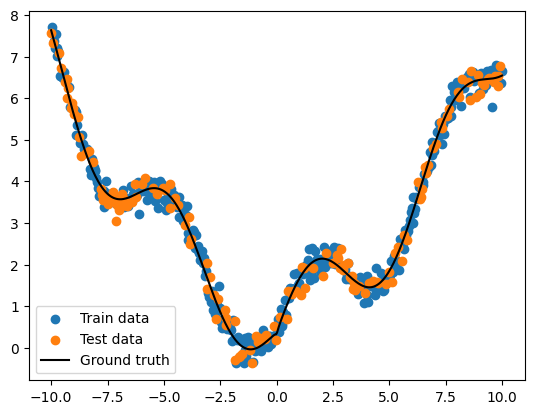

In [2]:
# plot the data

plt.scatter(X_train, y_train, label='Train data')
plt.scatter(X_test, y_test, label='Test data')
plt.plot(x, complex_nonlin_func(x), label='Ground truth', color='black')
plt.legend()
plt.show()


In [3]:
def mse_loss(predicted, target):
    # Reshape target to match predicted's shape
    target = target.reshape(predicted.shape)
    return np.mean((predicted - target) ** 2)

def mse_loss_grad(predicted, target):
    # Reshape target to match predicted's shape for gradient calculation
    target = target.reshape(predicted.shape)
    return 2 * (predicted - target) / predicted.shape[0]


# 2. Designing the MLP

In [4]:
# construct the MLP model

class MLP(Module):
    def __init__(self, layers, epochs=1000, lr=0.01, input_shape=1, output_shape=1):
        super().__init__()
        self.layers = layers
        self.epochs = epochs
        self.lr = lr
        self.loss = []
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.validation_loss = []

    def forward(self, X):
        # Also used as the function to get the output of the model
        A = X  # input layer, caches the input
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, dA):
        dZ = dA 
        # again we externally call the last layer
        for layer in reversed(self.layers):
            dZ = layer.backward(dZ)

    def inference(self, X):
        X = X.reshape(-1, self.input_shape)

        for layer in self.layers:
            layer.isInference = True
        
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        
        for layer in self.layers:
            layer.isInference = False
        
        return A
        
    def update_params(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W -= lr * layer.parameters['dW']
                layer.b -= lr * layer.parameters['db']

    def predict(self, X):
        A = X
        for layer in self.layers[:-1]:
            A = layer.forward(A)
        # 
        return A
    
    def reset(self):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.reset()
                
    def train_BGD(self, X, Y, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        # expands X to (m, features) 
        # feature number here is coded in self.input_shape
        X = X.reshape(-1, self.input_shape)

        for epoch in tqdm(range(epochs), desc="Training BGD"):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]
            
            # forward pass
            # it iterates all the layers except the last one
            A = self.forward(X_shuffled) 

            # here A is the predicted array
            # compute the loss using the MSE layer
            loss = mse_loss(A, Y_shuffled)
            self.loss.append(loss)

            # backward pass using the MSE layer
            dA = mse_loss_grad(A, Y_shuffled)
            self.backward(dA)
            
            # update the parameters
            self.update_params(lr)

    def train_MBGD(self, X, Y, batch_size=32, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        X = X.reshape(-1, self.input_shape)
        m = X.shape[0]

        for epoch in tqdm(range(epochs), desc="Training MBGD"):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]

                A = self.forward(X_batch)
                loss = mse_loss(A, Y_batch)
                self.loss.append(loss)

                dA = mse_loss_grad(A, Y_batch)
                self.backward(dA)
                self.update_params(lr)
                # Validation on the test dataset
                # A_test = self.inference(X_test)
                # val_loss = mse_loss(A_test, y_test)
                # self.validation_loss.append(val_loss)

    def train_SGD(self, X, Y, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        X = X.reshape(-1, self.input_shape)
        m = X.shape[0]

        for epoch in tqdm(range(epochs), desc="Training SGD"):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for i in range(m):
                X_sample = X_shuffled[i:i + 1]
                Y_sample = Y_shuffled[i:i + 1]

                A = self.forward(X_sample)
                loss = mse_loss(A, Y_sample)
                self.loss.append(loss)

                dA = mse_loss_grad(A, Y_sample)
                self.backward(dA)
                self.update_params(lr)
    
    def train_k_fold(self, X, Y, k=5, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        m = X.shape[0]
        fold_size = m // k # integer division, i.e. 103 // 5 = 20
        indices = np.arange(m) # 0, 1, 2, ..., m-1
        np.random.shuffle(indices) # shuffle the indices, train randomly

        fold = 1
        for i in range(k): # iterate over the folds, totally we train for k times
            val_start = i * fold_size
            val_end = val_start + fold_size if i < k - 1 else m # if it's the last fold, use the remaining data

            val_indices = indices[val_start:val_end] # takes the validation indices
            train_indices = np.concatenate([indices[:val_start], indices[val_end:]]) # takes all the indices except the validation indices

            X_train = X[train_indices]
            Y_train = Y[train_indices]
            X_val = X[val_indices]
            Y_val = Y[val_indices]

            self.reset()
            self.train_MBGD(X_train, Y_train, epochs=epochs, lr=lr) # we still use the mini-batch gradient descent, with a default bs of 32.
            
            A_val = self.inference(X_val)
            loss = mse_loss(A_val, Y_val)
            self.validation_loss.append(loss)

            print(f'Fold {fold}, Loss: {loss}')
            fold += 1


In [5]:

layers = [
        Linear(input_size=1, output_size=64),
        ReLU(),
        Linear(input_size=64, output_size=128),
        ReLU(),
        Linear(input_size=128, output_size=1)
    ]

# 3. Training the MLP Model

In [6]:
%%script true
epochs = 8000
lr = 0.3

# Creates the model    
mlp_model = MLP(layers, epochs=epochs, lr=lr)
if not trained:
    # Train the model with the generated data
    mlp_model.train_MBGD(X_train, y_train)
    trained = True
elif trained:
    mlp_model.reset()
    mlp_model.train_MBGD(X_train, y_train)


In [7]:
%%script true
plt.plot(mlp_model.loss, label='Training Loss')
plt.plot(mlp_model.validation_loss, label='Validation Loss')
plt.xlabel('Updates')
plt.ylabel('Loss')
# plt.yscale('log')
plt.title('Training and Validation Loss over Updates')
plt.legend()
plt.show()

# plot the fitted line
fitted = mlp_model.inference(x.reshape(-1,1))
# plt.scatter(X_train, y_train, label='Train data')
# plt.scatter(X_test, y_test, label='Test data')
plt.plot(x, fitted, label=f'Fitted line (Epochs: {epochs}, LR: {lr})', color='red')
plt.plot(x, complex_nonlin_func(x), label='Ground truth', color='black')
plt.legend()
plt.show()

# 4. Evaluating the model


In [8]:
# %%script true
epochs = 8000
lr = 0.1

eval_layers = [
        Linear(input_size=1, output_size=64),
        ReLU(),
        Linear(input_size=64, output_size=128),
        ReLU(),
        Linear(input_size=128, output_size=1)
    ]

# Creates the model    
model_evaluation = MLP(eval_layers, epochs=epochs, lr=lr)
if not trained:
    # Train the model with the generated data
    model_evaluation.train_k_fold(x, y, k=5, epochs=epochs, lr=lr)
    trained = True
elif trained:
    model_evaluation.reset()
    model_evaluation.train_k_fold(x,y,k=5, epochs=epochs, lr=lr)


Training MBGD: 100%|██████████| 8000/8000 [00:12<00:00, 636.71it/s]


Fold 1, Loss: 0.06319338691898538


Training MBGD: 100%|██████████| 8000/8000 [00:12<00:00, 621.56it/s]


Fold 2, Loss: 0.054447114450947735


Training MBGD: 100%|██████████| 8000/8000 [00:12<00:00, 662.03it/s]


Fold 3, Loss: 0.09368914090639784


Training MBGD: 100%|██████████| 8000/8000 [00:14<00:00, 558.54it/s]


Fold 4, Loss: 0.07400357374842177


Training MBGD: 100%|██████████| 8000/8000 [00:12<00:00, 621.44it/s]

Fold 5, Loss: 0.05243003560476707


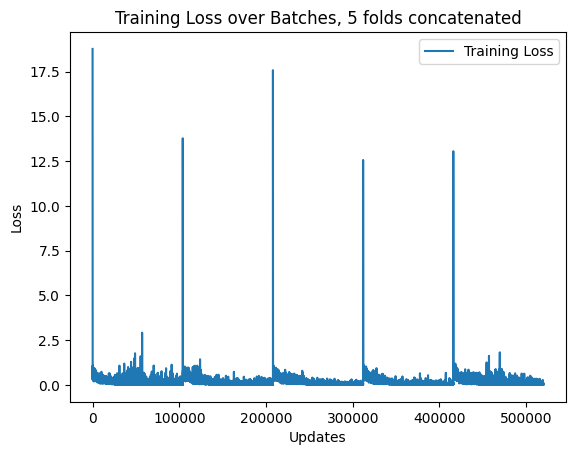

In [9]:
plt.plot(model_evaluation.loss, label='Training Loss')
# plt.plot(model_evaluation.validation_loss, label='Validation Loss')
plt.xlabel('Updates')
plt.ylabel('Loss')
# plt.yscale('log')
plt.title('Training Loss over Batches, 5 folds concatenated')
plt.legend()
plt.show()

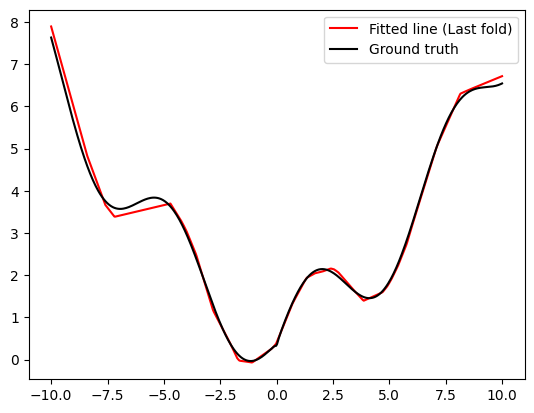

In [10]:
fitted = model_evaluation.inference(x.reshape(-1,1))
# plt.scatter(X_train, y_train, label='Train data')
# plt.scatter(X_test, y_test, label='Test data')
plt.plot(x, fitted, label=f'Fitted line (Last fold)', color='red')
plt.plot(x, complex_nonlin_func(x), label='Ground truth', color='black')
plt.legend()
plt.show()

In [11]:
avg_val_loss = np.mean(model_evaluation.validation_loss)
print(f'Average validation loss: {avg_val_loss}')
print(f'Hyperparameters are: Epochs: {epochs}, LR: {lr}')
print("Model structure:")
for i, layer in enumerate(eval_layers):
    print(f"Layer {i + 1}: {layer.__class__.__name__}",end='')
    if isinstance(layer, Linear):
        print(f"Input size: {layer.input_size}, Output size: {layer.output_size}")
    else:
        print()

Average validation loss: 0.06755265032590395
Hyperparameters are: Epochs: 8000, LR: 0.1
Model structure:
Layer 1: LinearInput size: 1, Output size: 64
Layer 2: ReLU
Layer 3: LinearInput size: 64, Output size: 128
Layer 4: ReLU
Layer 5: LinearInput size: 128, Output size: 1
